<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-MCD/blob/main/11_BERT_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>BERT</h1>

En esta notebook exploraremos el uso de modelos tipo BERT para resolver la tarea de *Análisis de Sentimientos*. Esto lo haremos de dos formas:

1. Haciendo fine-tuning a un modelo BERT.
2. Usando los embeddings generados por BERT como features para un algoritmo de ML.

Usaremos modelos pre-entrenados almacenados en [HuggingFace](https://huggingface.co/).

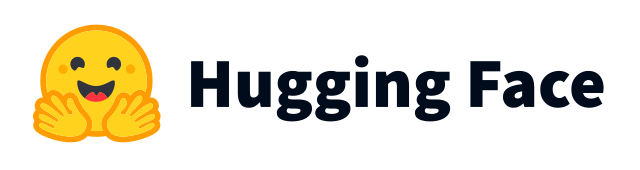

---

*Hugging Face, Inc. es una empresa estadounidense conocida por su biblioteca de transformadores creada para aplicaciones de procesamiento de lenguaje natural y su plataforma que permite a los usuarios compartir [datasets](https://huggingface.co/datasets) y [modelos](https://huggingface.co/models) de aprendizaje automático.  Su campo de acción principal es el NLP, pero también se centra en otras áreas del ML, como la visión de máquina, el aprendizaje por refuerzo y el aprendizaje supervisado.*

---

Regresaremos al dataset de 50K reviews de [IMDB](https://www.imdb.com/). Recordemos los rendimientos que habíamos obtenido:

* **Naive Bayes y ML clásico**. Accuracy: $\sim$ 75-82%.
* **Embeddings de Word2Vec, GloVe, Doc2Vec**. Accuracy: $\sim$ 85-87%.
* **BERT**: Accuracy $\sim$ ❓

# 1. Dataset

In [7]:
!gdown 18kGdlhOiQNS61wUK7uPbdquKL3XJrgzf

Downloading...
From: https://drive.google.com/uc?id=18kGdlhOiQNS61wUK7uPbdquKL3XJrgzf
To: /content/IMDB.csv
100% 66.2M/66.2M [00:01<00:00, 51.8MB/s]


Leemos el dataset y hacemos la división en

* Entrenamiento: 30,000
* Validación: 10,000
* Prueba: 10,000

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

imdb_df = pd.read_csv('IMDB.csv')
display(imdb_df)

y = LabelEncoder().fit_transform(imdb_df['sentiment'].values)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(imdb_df['review'].values, y, test_size=0.2, random_state=642, stratify=y)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train, test_size=0.25, random_state=473, stratify=y_train)
print(f"Training set size: {len(X_train_raw)}")
print(f"Validation set size: {len(X_val_raw)}")
print(f"Test set size: {len(X_test_raw)}")

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Training set size: 30000
Validation set size: 10000
Test set size: 10000


In [ ]:
import numpy as np

random_idxs = np.random.choice(len(X_train_raw), size=4, replace=False)

for k in random_idxs:
    print(f"Review:\n{X_train_raw[k]}")

Review:
I had heard good things about "States of Grace" and came in with an open mind. I thought that "God's Army" was okay, and I thought that maybe Dutcher had improved and matured as a filmmaker. The film began with some shaky acting, and I thought, "well, maybe it will get better." Unfortunately, it never did. The picture starts out by introducing two elders -- Mormon missionaries -- and it seems that the audience will get to know them and grow to care about them. Instead, the story degenerates into a highly improbable series of unfortunate events highlighting blatant disobedience by the missionaries (something that undeniably exists, but rarely on the level that Dutcher portrays) and it becomes almost laughable.<br /><br />Dutcher's only success in this movie is his successful alienation of his target audience. By unrealistically and inaccurately portraying the lives of Mormon missionaries, Dutcher accomplishes nothing more than angering his predominantly Mormon audience. The film

#2. Limpieza y preprocesamiento

En los modelos de lenguaje modernos como BERT y sus sucesores, el preprocesamiento tradicional del texto (como la eliminación de stopwords, lematización o stemming) ya no es necesario ni recomendable.

Estos modelos están diseñados para entender el contexto y la estructura del lenguaje tal como aparece en el texto crudo, incluyendo palabras funcionales que aportan significado contextual.

Sin embargo, sí es común limpiar el texto de artefactos no lingüísticos, como etiquetas HTML, códigos de escape, URLs, o caracteres especiales irrelevantes.

En su lugar, el preprocesamiento se limita generalmente a la tokenización mediante el tokenizador específico del modelo (por ejemplo, WordPiece para BERT), la adición de tokens especiales ([CLS], [SEP]), y el relleno o truncamiento de secuencias para ajustarlas a una longitud fija.

Conservar el texto original permite al modelo aprovechar al máximo su capacidad contextual y semántica.

In [9]:
import re
import html

def clean_text(text):
    # Decodificar entidades HTML
    text = html.unescape(text)
    # Eliminar etiquetas HTML
    text = re.sub(r'<[^>]+>', ' ', text)
    # Normalizar espacios
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [10]:
train_docs = [clean_text(doc) for doc in X_train_raw]
test_docs = [clean_text(doc) for doc in X_test_raw]
val_docs = [clean_text(doc) for doc in X_val_raw]

In [ ]:
for k in random_idxs:
    print(f"Review:\n{train_docs[k]}")

Review:
I had heard good things about "States of Grace" and came in with an open mind. I thought that "God's Army" was okay, and I thought that maybe Dutcher had improved and matured as a filmmaker. The film began with some shaky acting, and I thought, "well, maybe it will get better." Unfortunately, it never did. The picture starts out by introducing two elders -- Mormon missionaries -- and it seems that the audience will get to know them and grow to care about them. Instead, the story degenerates into a highly improbable series of unfortunate events highlighting blatant disobedience by the missionaries (something that undeniably exists, but rarely on the level that Dutcher portrays) and it becomes almost laughable. Dutcher's only success in this movie is his successful alienation of his target audience. By unrealistically and inaccurately portraying the lives of Mormon missionaries, Dutcher accomplishes nothing more than angering his predominantly Mormon audience. The film in no way 

# Finetuning con la clase [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) de transformers

`Trainer` es una API de HuggingFace para hacer fine-tuning a modelos para tareas específicas. Hay dos variantes:

* **`Trainer`**: API basada en Pytorch. Usaremos esta
* **`TFTrainer`**: API basada en Tensorflow. Obsoleta, ya no se encuentra en la versión más reciente de transformers.

Se requiere que definamos 2 objetos:

* [`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments): Especifica los hiperparámetros de entrenamiento. Todas las opciones se pueden encontrar en [docs](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments). Por ejemplo, especificamos que queremos evaluar después de cada epoch de entrenamiento, nos gustaría guardar el modelo cada epoch, establecemos la tasa de aprendizaje, el tamaño del lote a utilizar para el entrenamiento/evaluación, para cuántas epochs entrenar, etc.
* `Trainer`: [Docs](https://huggingface.co/transformers/main_classes/trainer.html#id1).


## Preparación del dataset

In [ ]:
num_training_docs = 2000
num_validation_docs = 1000

sample_train_docs, _, sample_train_labels, _ = train_test_split(train_docs, y_train,
                                                                train_size=num_training_docs,
                                                                random_state=777,
                                                                stratify=y_train)

sample_val_docs, _, sample_val_labels, _ = train_test_split(val_docs, y_val,
                                                            train_size=num_validation_docs,
                                                            random_state=777,
                                                            stratify=y_val)

sample_test_docs, _, sample_test_labels, _ = train_test_split(test_docs, y_test,
                                                              train_size=num_validation_docs,
                                                              random_state=777,
                                                              stratify=y_test)

In [ ]:
train_df = pd.DataFrame(data={
                        # 'text': train_docs,
                        'text': sample_train_docs,
                        # 'label': y_train
                        'label': sample_train_labels
                    })

val_df = pd.DataFrame(data={
                        # 'text': val_docs,
                        'text': sample_val_docs,
                        # 'label': y_val
                        'label': sample_val_labels
                    })

test_df = pd.DataFrame(data={
                        'text': test_docs,
                        'label': y_test
                    })

train_df

,text,label
0,"THIS FILM IS LAME, LAME, LAME!!!!! It takes a ...",0
1,** May contain spoilers ** Horrible. Just horr...,0
2,It must be the most corniest TV show on the ai...,0
3,**** MILD SPOILERS _ BUT YOU PROBABLY KNOW THE...,0
4,I found the film Don't Look In The Basement to...,1
...,...,...
1995,"Acting was weak, but in a horror flick, I can ...",0
1996,Not only was this movie better than all the fi...,1
1997,"This is one of my all time favorite movies, it...",1
1998,Ever have one of those sneezes that seems to b...,0


In [ ]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

## Tokenización

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tamaño de vocabulario:

In [ ]:
tokenizer.vocab_size

Inspeccionemos el vocabulario:

In [ ]:
tokenizer.get_vocab()

In [ ]:
# Función para tokenizar los textos
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

### Ejemplo de Tokenización

In [ ]:
train_df.iloc[0]['text']

"THIS FILM IS LAME, LAME, LAME!!!!! It takes a lot to bring me to over-exaggeration about a movie, but this movie stunk up my house!! I haven't even finished the movie yet and I had to stop to comment on how bad this movie is. I'VE NEVER DONE THAT!! As a consumer, do not spend your money on this film. Wait until it comes out on a cable channel or something. It's barely TV worthy. I REALLY HATE TRASHING A MOVIE, BUT THIS MOVIE IS TRASH! Barely above porn. Should have and X rating! Good plot, some frontal nudity (if that floats your boat), but HORRIBLE high school level acting. Don't know how this movie received distribution. (Must have been a contractual thing.) Really, if you really like watching good movies, don't waste you time with this one. From one movie lover to another. YOU WILL BE MAD AT YOURSELF! Let me say this as well, if you've been through something like this perhaps you can relate and it will have some value for you. In that case I say watch it, you may take something awa

In [ ]:
sample_text = train_df.iloc[0]['text']
sample_encodings = tokenizer(sample_text, padding="max_length", truncation=True, max_length=128)
print(f"Texto:\n{sample_text}")
print(f"Encodings:\n{sample_encodings['input_ids']}")
print(f"Tokens:\n{tokenizer.convert_ids_to_tokens(sample_encodings['input_ids'])}")

Texto:
THIS FILM IS LAME, LAME, LAME!!!!! It takes a lot to bring me to over-exaggeration about a movie, but this movie stunk up my house!! I haven't even finished the movie yet and I had to stop to comment on how bad this movie is. I'VE NEVER DONE THAT!! As a consumer, do not spend your money on this film. Wait until it comes out on a cable channel or something. It's barely TV worthy. I REALLY HATE TRASHING A MOVIE, BUT THIS MOVIE IS TRASH! Barely above porn. Should have and X rating! Good plot, some frontal nudity (if that floats your boat), but HORRIBLE high school level acting. Don't know how this movie received distribution. (Must have been a contractual thing.) Really, if you really like watching good movies, don't waste you time with this one. From one movie lover to another. YOU WILL BE MAD AT YOURSELF! Let me say this as well, if you've been through something like this perhaps you can relate and it will have some value for you. In that case I say watch it, you may take somethi

## Finetuning

### Leer el modelo pre-entrenado

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           num_labels=2
                                                           )

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Definir las clases `TrainingArguments` y `Trainer`

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

In [ ]:
from transformers import TrainingArguments

batch_size = 8
metric_name = 'accuracy'
num_epocas = 1

args = TrainingArguments(
    output_dir=f"bert-finetuning",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epocas,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    report_to="none"
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2765937096.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Entrenar (Finetuning)

In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.391367,0.840000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=250, training_loss=0.46363385009765623, metrics={'train_runtime': 3463.7835, 'train_samples_per_second': 0.577, 'train_steps_per_second': 0.072, 'total_flos': 131555527680000.0, 'train_loss': 0.46363385009765623, 'epoch': 1.0})

### Guardar el modelo

In [ ]:
# Save the entire model as a HDF5 file
model.save_pretrained("BERT_saved_model")

# Optionally, if you also want to save the tokenizer used during training
tokenizer.save_pretrained("BERT_saved_model_tokenizer")

('BERT_saved_model_tokenizer/tokenizer_config.json',
 'BERT_saved_model_tokenizer/special_tokens_map.json',
 'BERT_saved_model_tokenizer/vocab.txt',
 'BERT_saved_model_tokenizer/added_tokens.json',
 'BERT_saved_model_tokenizer/tokenizer.json')

### Leer el modelo con finetuning

Podemos leer el modelo guardado para no hacer el finetuning otra vez

In [ ]:
!gdown --folder 1LITbmTTAPiRslRJD_q7DDHUCn3xZTE27

Retrieving folder contents
Processing file 18WrPWu7oyczUFy636UM2qImzfWsqLRNO config.json
Processing file 1rnts5uQKYpESdeHO7pwKspOqwz5fnleG model.safetensors
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=18WrPWu7oyczUFy636UM2qImzfWsqLRNO
To: /content/Sampled2K_finetuned_model/config.json
100% 681/681 [00:00<00:00, 2.31MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1rnts5uQKYpESdeHO7pwKspOqwz5fnleG
From (redirected): https://drive.google.com/uc?id=1rnts5uQKYpESdeHO7pwKspOqwz5fnleG&confirm=t&uuid=b2b4ff3a-722d-410f-adb7-b143640af324
To: /content/Sampled2K_finetuned_model/model.safetensors
100% 438M/438M [00:07<00:00, 59.1MB/s]
Download completed


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

# Cargar modelo desde la carpeta guardada
model = AutoModelForSequenceClassification.from_pretrained("Sampled2K_finetuned_model")

# Definimos training_args y el Trainer para usar el método predict
training_args = TrainingArguments(
    output_dir="./temp",
    per_device_eval_batch_size=8,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
)

/tmp/ipython-input-758438933.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Visualizando la atención:

https://huggingface.co/spaces/exbert-project/exbert

### Evaluar

Evaluar

In [ ]:
eval_results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
print(f"Test Evaluation Results: {eval_results}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Evaluation Results: {'eval_loss': 0.39162489771842957, 'eval_accuracy': 0.8432, 'eval_runtime': 4322.3386, 'eval_samples_per_second': 2.314, 'eval_steps_per_second': 0.289, 'epoch': 1.0}


Generar las predicciones

In [ ]:
predictions = trainer.predict(tokenized_test_dataset)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluación externa

F1 Score: 0.8511769172361427


Text(70.72222222222221, 0.5, 'True')

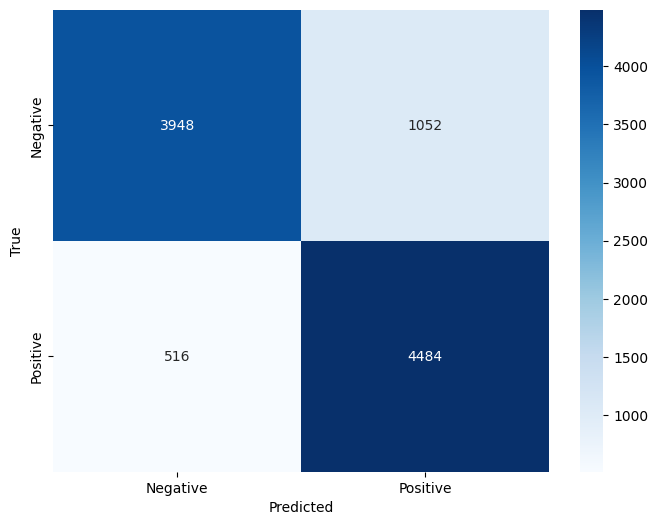

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')

### Finetuning con todo el dataset

<h4>Resultados</h4>

<h5>Resumen</h5>

| Métrica | Valor |
|---------|-------|
| **Accuracy Final** | 92.37% |
| **Loss Final** | 0.3292 |
| **Duración Entrenamiento** | 13 minutos 30 segundos |
| **Épocas** | 3 |
| **Batch Size** | 16 |


<h5>Reporte de Clasificación</h5>

| Clase | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| **Negative** | 0.94 | 0.90 | 0.92 | 5,000 |
| **Positive** | 0.91 | 0.94 | 0.93 | 5,000 |
| **Accuracy** | | | 0.92 | 10,000 |
| **Macro Avg** | 0.92 | 0.92 | 0.92 | 10,000 |
| **Weighted Avg** | 0.92 | 0.92 | 0.92 | 10,000 |

<h5>Matriz de confusión</h5>

<img src="https://drive.google.com/uc?id=17Tnk-vnBi3HMkxTnOIeB2jRHI9EMHer-" width="500">

# Embeddings

El enfoque de embeddings pre-entrenados con MLP consiste en utilizar modelos de lenguaje entrenados en grandes corpus de texto para convertir documentos en vectores de características numéricas de alta dimensionalidad. Estos embeddings capturan relaciones semánticas y sintácticas del lenguaje que son difíciles de obtener con técnicas tradicionales como bag-of-words o TF-IDF. Una vez obtenidos los embeddings, se alimentan a una red neuronal multicapa que aprende a mapear estas representaciones vectoriales a las clases objetivo.

Este método separa la extracción de características del proceso de clasificación, permitiendo aprovechar el conocimiento lingüístico de modelos entrenados en millones de documentos mientras se mantiene la simplicidad de arquitecturas de clasificación tradicionales.

Usaremos dos modelos para generar los embeddings:

* BERT Base
* `all-MiniLM-L6-v2`

In [11]:
num_training_docs = 2000
num_validation_docs = 1000

sample_train_docs, _, sample_train_labels, _ = train_test_split(train_docs, y_train,
                                                                train_size=num_training_docs,
                                                                random_state=777,
                                                                stratify=y_train)

sample_val_docs, _, sample_val_labels, _ = train_test_split(val_docs, y_val,
                                                            train_size=num_validation_docs,
                                                            random_state=777,
                                                            stratify=y_val)

sample_test_docs, _, sample_test_labels, _ = train_test_split(test_docs, y_test,
                                                              train_size=num_validation_docs,
                                                              random_state=777,
                                                              stratify=y_test)

## Cargamos el tokenizador y modelo

In [1]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [2]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Obtenemos los embeddings

Con esta función obtenemos los embeddings de cada texto

In [ ]:
import torch

device = torch.device("cpu")  # Define el dispositivo como CPU
model.to(device)  # Mueve el modelo a la CPU

def get_cls_embedding(texts, verbose=False):
    # Tokeniza los textos: padding, truncamiento y conversión a tensores PyTorch
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)

    if verbose:
        # Calcula la longitud real de tokens (excluyendo padding)
        tokenized_length = len([idx for idx in encoded_input['input_ids'][0]
                               if idx != 0])
        print(f'Tokenized length: {tokenized_length}')

    # Mueve todos los inputs tokenizados al dispositivo (CPU/GPU)
    encoded_input = {key: value.to(device) for key, value in encoded_input.items()}

    # Desactiva el cálculo de gradientes para inferencia (más eficiente)
    with torch.no_grad():
        # Pasa los inputs por el modelo y obtiene todas las salidas
        model_output = model(**encoded_input, output_hidden_states=True)

    if verbose:
        # Muestra la forma del último layer de hidden states
        print(model_output['hidden_states'][-1].shape)

    # Extrae el embedding del token [CLS] (posición 0) del último layer
    cls_embeddings = model_output['hidden_states'][-1][:, 0, :]

    # Convierte a numpy array para uso fuera de PyTorch
    return cls_embeddings.numpy()

Imprimamos información sobre las formas de las salidas para ilustrar lo que estamos obteniendo:

In [ ]:
_ = get_cls_embedding(sample_train_docs[0],verbose=True)

Tokenized length: 149
torch.Size([1, 149, 768])


In [ ]:
import numpy as np

train_embeddings = np.zeros((len(sample_train_docs), 768))

for i, text in enumerate(sample_train_docs):
    train_embeddings[i] = get_cls_embedding(text).reshape(-1,)

In [ ]:
val_embeddings = np.zeros((len(sample_val_docs), 768))

for i, text in enumerate(sample_val_docs):
    val_embeddings[i] = get_cls_embedding(text).reshape(-1,)

### Los descargamos si ya los hemos generado anteriormente

Podemos leerlos los que ya hemos generado previamente

In [3]:
!gdown 1Cro8bXTjevcsTn40fI6q73u1ZBE6FiXE
!gdown 1Ob_vDLKZ3t9CCmgDqR0K6aqYm7Ainr6d
!gdown 1-B4yLyGj6WTuvB-TNAg8b695STJFIrWQ
!gdown 1-9f0JobxEThc6BdYzzInGGRPXaMbmc9w

Downloading...
From: https://drive.google.com/uc?id=1Cro8bXTjevcsTn40fI6q73u1ZBE6FiXE
To: /content/imdb sample train embeddings bert.npy
100% 12.3M/12.3M [00:00<00:00, 134MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ob_vDLKZ3t9CCmgDqR0K6aqYm7Ainr6d
To: /content/imdb sample train labels.npy
100% 16.1k/16.1k [00:00<00:00, 10.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-B4yLyGj6WTuvB-TNAg8b695STJFIrWQ
To: /content/imdb sample test embeddings bert.npy
100% 6.14M/6.14M [00:00<00:00, 58.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-9f0JobxEThc6BdYzzInGGRPXaMbmc9w
To: /content/imdb sample test labels.npy
100% 8.13k/8.13k [00:00<00:00, 18.9MB/s]


In [4]:
import numpy as np

train_embeddings = np.load('imdb sample train embeddings bert.npy')
val_embeddings = np.load('imdb sample test embeddings bert.npy')
train_labels = np.load('imdb sample train labels.npy')
val_labels = np.load('imdb sample test labels.npy')

## Entrenar un clasificador de ML

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clfs = [
    RandomForestClassifier(),
    SVC(C=2),
    LogisticRegression(max_iter=10000)
]

names = [
    'Random Forest',
    'SVC',
    'Logistic Regression'
]

for name,clf in zip(names,clfs):
    pl = make_pipeline(StandardScaler(), clf)
    pl.fit(train_embeddings, train_labels)
    y_pred = pl.predict(val_embeddings)
    f1 = f1_score(val_labels, y_pred)
    print(f"Clasificador: {name}\n\tF1-score: {round(f1,3)}")


Clasificador: Random Forest
	F1-score: 0.749
Clasificador: SVC
	F1-score: 0.792
Clasificador: Logistic Regression
	F1-score: 0.767


## Modelos adicionales

all-MiniLM-L6-v2 es un modelo de transformador compacto basado en la arquitectura MiniLM que genera embeddings de texto de 384 dimensiones. Fue entrenado mediante destilación de conocimiento a partir de modelos más grandes, manteniendo un rendimiento competitivo con solo 22 millones de parámetros. El modelo utiliza 6 capas de atención y está optimizado para tareas de recuperación de información y similitud semántica, procesando secuencias de hasta 512 tokens y produciendo representaciones vectoriales que capturan el significado contextual del texto de entrada.

Tarda alrededor de 6 minutos

In [12]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
train_embeddings = model.encode(sample_train_docs)
test_embeddings = model.encode(sample_test_docs)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")

Train embeddings shape: (2000, 384)
Test embeddings shape: (1000, 384)


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clfs = [
    RandomForestClassifier(),
    SVC(C=2),
    LogisticRegression(max_iter=10000)
]

names = [
    'Random Forest',
    'SVC',
    'Logistic Regression'
]

for name,clf in zip(names,clfs):
    clf.fit(train_embeddings, sample_train_labels)
    y_pred = clf.predict(test_embeddings)
    f1 = f1_score(sample_test_labels, y_pred)
    print(f"Clasificador: {name}\n\tF1-score: {round(f1,3)}")

Clasificador: Random Forest
	F1-score: 0.759
Clasificador: SVC
	F1-score: 0.801
Clasificador: Logistic Regression
	F1-score: 0.802
